In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set some formatting options for pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
# Import all required raw data files, I will ignore earnings and stock info from euronext now
# To make things easier, my index will always we a combination of stock_isin and date
balance_sheet_yahoo = pd.read_csv(r'raw_data\balance_sheet_yahoo.csv', sep='|')
cashflow_yahoo = pd.read_csv(r'raw_data\cashflow_yahoo.csv', sep='|')
financials_yahoo = pd.read_csv(r'raw_data\financials_yahoo.csv', sep='|')
price_yahoo = pd.read_csv(r'raw_data\price_yahoo.csv', sep='|')
stock_info_yahoo = pd.read_csv(
    r'raw_data\stock_info_yahoo.csv', sep='|')
stock_info_euronext = pd.read_csv(
    r'raw_data\stock_info_euronext.csv', sep='|')


In [3]:
# The rows that make up a distinct combination of stock_isin and date (year-end) will make up by full dataset
df = financials_yahoo.groupby(['stock_isin', 'date']).size().reset_index().drop(columns = [0])
df['financial_year_end'] = pd.to_datetime(df['date'])
print(f'The end dataset could contain {len(df.index)} sets of financial statements')


The end dataset contains 5552 data points


In [4]:
# We first focus on finding our predictor which which will be the one year holding return following the financial year end
# I want to focus on total return which will include dividends, this means days that pay a dividend get a higher return
price_yahoo['close_price_plus_dividends'] = price_yahoo['close_price'] + \
    price_yahoo['dividends']
price_yahoo.head()


,date,open_price,high_price,low_price,close_price,trading_volume,dividends,stock_splits,stock_isin,adjusted_close_price,close_price_plus_dividends
0,2019-07-12,83.686,86.374,79.656,79.656,40831.000,0.000,0.000,BMG9156K1018,NaN,79.656
1,2019-07-15,79.656,80.596,77.736,77.736,8810.000,0.000,0.000,BMG9156K1018,NaN,77.736
2,2019-07-16,77.736,77.736,76.777,77.736,21400.000,0.000,0.000,BMG9156K1018,NaN,77.736
3,2019-07-17,77.736,77.736,77.266,77.736,12966.000,0.000,0.000,BMG9156K1018,NaN,77.736
4,2019-07-18,76.786,76.786,73.907,76.777,4789.000,0.000,0.000,BMG9156K1018,NaN,76.777


In [5]:
# First I will sort by date for each unique ISN and drop irrelevant columns
price_yahoo.sort_values(["stock_isin", "date"],
               axis=0, ascending=True,
               inplace=True)
price_yahoo = price_yahoo[['stock_isin', 'date', 'close_price', 'dividends','close_price_plus_dividends']]
price_yahoo['date'] = pd.to_datetime(price_yahoo['date'])
price_yahoo.head()


,stock_isin,date,close_price,dividends,close_price_plus_dividends
1355072,AN8068571086,2017-02-23,62.485,0.000,62.485
1355073,AN8068571086,2017-02-24,62.791,0.000,62.791
1355074,AN8068571086,2017-02-27,63.113,0.000,63.113
1355075,AN8068571086,2017-02-28,62.807,0.000,62.807
1355076,AN8068571086,2017-03-01,64.007,0.000,64.007


In [6]:
price_yahoo['daily_pct_change'] = price_yahoo['close_price'].pct_change()
price_yahoo['daily_pct_change_plus_one'] = price_yahoo['daily_pct_change'] + 1
price_yahoo.head()

,stock_isin,date,close_price,dividends,close_price_plus_dividends,daily_pct_change,daily_pct_change_plus_one
1355072,AN8068571086,2017-02-23,62.485,0.000,62.485,NaN,NaN
1355073,AN8068571086,2017-02-24,62.791,0.000,62.791,0.005,1.005
1355074,AN8068571086,2017-02-27,63.113,0.000,63.113,0.005,1.005
1355075,AN8068571086,2017-02-28,62.807,0.000,62.807,-0.005,0.995
1355076,AN8068571086,2017-03-01,64.007,0.000,64.007,0.019,1.019


In [7]:
# I need a function to find the relevant returns now following a year end
def one_year_return(stock_isin, year_end, pricing_return_df, reporting_lag_period_days=90):
  year_end_formatted = datetime.datetime.strptime(year_end, '%Y-%m-%d')
  data_availability_start_date = year_end_formatted + \
      datetime.timedelta(days=reporting_lag_period_days)
  data_availability_end_date = data_availability_start_date + \
      datetime.timedelta(days = 365) # Can be improved to account for leap years
  filtered_isin = pricing_return_df[pricing_return_df['stock_isin'] == stock_isin]
  mask = (filtered_isin['date'] > data_availability_start_date) & (filtered_isin['date'] <= data_availability_end_date)
  try:
    filtered_dates = filtered_isin.loc[mask]
    one_year_holding_return = filtered_dates['daily_pct_change_plus_one'].prod() - 1
    trading_days = len(filtered_dates.index)
  except:
    one_year_holding_return = np.nan
  return one_year_holding_return, trading_days, data_availability_start_date, data_availability_end_date


stock_isin = 'AN8068571086'
financial_year_end = '2017-02-23'
one_year_holding_return, trading_days, data_availability_start_date, data_availability_end_date = one_year_return(
    stock_isin, financial_year_end,  price_yahoo)
print(f'''Compound return for {stock_isin} with a financial year-end of {financial_year_end}
  from {data_availability_start_date} to {data_availability_end_date}
  is {one_year_holding_return} covering {trading_days} trading days''')


Compound return for AN8068571086 with a financial year-end of 2017-02-23
  from 2017-05-24 00:00:00 to 2018-05-24 00:00:00
  is -0.010726826787559318 covering 255 trading days


In [8]:
# Add our predictor to our dataset
df[['one_year_holding_return', 'trading_days', 'return_calc_start_date', 'return_calc_end_date']] = df.apply(lambda x: one_year_return(
    x['stock_isin'], x['date'], price_yahoo), axis=1, result_type='expand')


In [9]:
# Testing
df[df['stock_isin'] == 'AN8068571086'].head()


,stock_isin,date,financial_year_end,one_year_holding_return,trading_days,return_calc_start_date,return_calc_end_date
0,AN8068571086,2017-12-31,2017-12-31,-0.231,255,2018-03-31,2019-03-31
1,AN8068571086,2018-12-31,2018-12-31,-0.663,256,2019-03-31,2020-03-30
2,AN8068571086,2019-12-31,2019-12-31,0.973,256,2020-03-30,2021-03-30
3,AN8068571086,2020-12-31,2020-12-31,0.543,233,2021-03-31,2022-03-31


Return from 2018-03-31 to 2019-03-31 is -23%
Return from 2019-03-31 to 2020-03-30 is -66%
Return from 2020-03-30 to 2021-03-30 is 97%
Return from 2021-03-31 to 2022-03-31 is 54%


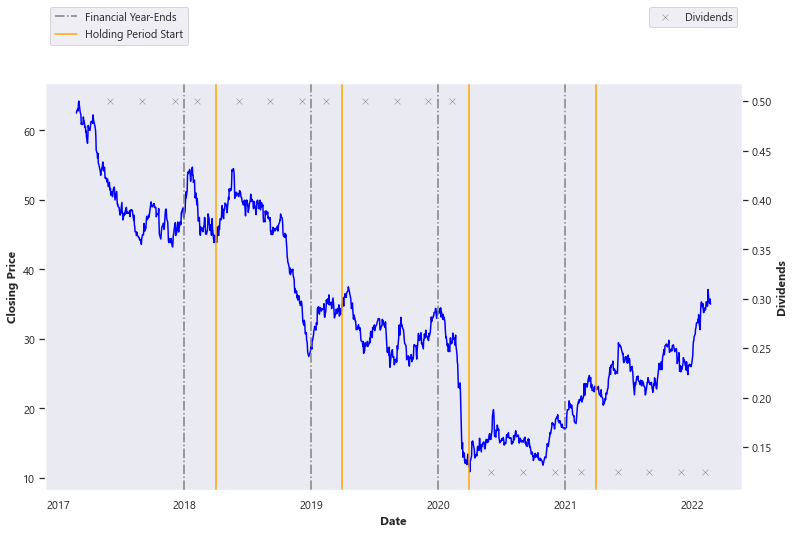

In [26]:
single_stock_all_info = price_yahoo[price_yahoo['stock_isin'] == 'AN8068571086']
single_stock_df = df[df['stock_isin'] == 'AN8068571086']
# Dividend events
actual_dividend_events = single_stock_all_info[single_stock_all_info['dividends'] != 0]
sns.set_theme(style='dark', font='Segoe UI')
fig, ax1 = plt.subplots(figsize=(12.5, 7.5))
ax2 = ax1.twinx()
# Add line plot for closing price
sns.lineplot(x='date', y='close_price', data=single_stock_all_info,
             ax=ax1, color='blue', label='Closing Price')
# Add lines for year ends
financial_year_ends = [x.strftime('%Y-%m-%d')
             for x in single_stock_df['financial_year_end'].to_list()]
for year_end in financial_year_ends:
  line2 = ax1.axvline(x=[year_end], color='grey', linestyle='dashdot', label='Financial Year-Ends')
# Add lines calculating returns
holding_period_starts = [x.strftime('%Y-%m-%d')
                         for x in single_stock_df['return_calc_start_date'].to_list()]
for holding_period in holding_period_starts:
  line3 = ax1.axvline(x=[holding_period], color='orange',
              linestyle='-', label='Holding Period Start')
# Rename y-axis
ax1.set_ylabel('Closing Price', weight='bold')
ax2.set_ylabel('Dividends', weight='bold')
# Rename x-axis
ax1.set_xlabel('Date', weight='bold')
# Add scatter plot for dividend events
sns.scatterplot(x='date', y='dividends',
                data=actual_dividend_events, ax=ax2, marker = 'x', color='grey')
# Legends
ax1.legend(handles=[line2, line3],
           loc='upper left', bbox_to_anchor=(0, 1.2))
ax2.legend(labels=["Dividends"], loc='upper right', bbox_to_anchor=(1, 1.2))
# Add some text to right of graph
commentary = list()
for index, row in single_stock_df.iterrows():
  start_date = row['return_calc_start_date'].strftime('%Y-%m-%d')
  end_date = row['return_calc_end_date'].strftime('%Y-%m-%d')
  percentage_return = "{:.0%}".format(row['one_year_holding_return'])
  commentary.append(f'Return from {start_date} to {end_date} is {percentage_return}')
textstr = '\n'.join(commentary)
print(textstr)



In [35]:
# Save to csv only where there are at least 200 trading days
df.query('trading_days >= 200').to_csv(
    'dataset/y_pred.csv', sep='|', index=False)